#### Рассчёт метрик Retrieval моделей

### Загрузка датасета

In [5]:
import pandas as pd


train_df = pd.read_csv('../data/ostap_train.csv')
test_df = pd.read_csv('../data/ostap_test.csv')


train_df.head()

question  \
0  Как ты проводишь свободное время?   
1      Какой у тебя план на будущее?   
2         Какой у тебя любимый цвет?   
3                Ты веришь в судьбу?   
4            Что ты думаешь о любви?   

                                              answer  
0                  Любителя бьют, а время — не ждет!  
1  План на будущее? Широкие массы миллиардеров уж...  
2  Вы мне в конце концов не художник, не дизайнер...  
3  Кому и кобыла невеста, а я верю только в удачу...  
4  Скоро только кошки родятся, а любовь — это про...

##### Baseline модель - предобученная embedding модель

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+cu124
True


In [4]:
from sentence_transformers import SentenceTransformer

model_bge = SentenceTransformer('BAAI/bge-m3', device=device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

##### подготовка данных для бенчмарка

In [7]:
corpus = test_df['answer']
queries = test_df['question']

corpus = dict(zip(map(str, range(len(corpus))), corpus)) 
queries = dict(zip(map(str, range(len(queries))), queries))

In [9]:
# --- Step 1: Deduplicate the corpus ---

# This dictionary will help us check if a text has been seen before.
seen_texts = {}

# new_corpus will hold the deduplicated texts with new document IDs.
new_corpus = {}

# This dictionary maps old corpus IDs to the new corpus IDs.
old_to_new = {}

new_id = 0
for old_id, text in corpus.items():
    if text in seen_texts:
        # If this text is a duplicate, map the old ID to the existing new ID.
        old_to_new[old_id] = seen_texts[text]
    else:
        # Otherwise, add the text as a new entry.
        new_id_str = str(new_id)
        new_corpus[new_id_str] = text
        seen_texts[text] = new_id_str
        old_to_new[old_id] = new_id_str
        new_id += 1

print(f"Original corpus size: {len(corpus)}")
print(f"Deduplicated corpus size: {len(new_corpus)}")

# --- Step 2: Update the relevant docs mapping ---

new_relevant_docs = {}
for qid in queries.keys():
    new_relevant_docs[qid] = {old_to_new[qid]}

Original corpus size: 226
Deduplicated corpus size: 219


#### Benchmark при помощи InformationRetrievalEvaluator

In [11]:
# --- (Optional) Use the deduplicated corpus in your evaluator ---
from sentence_transformers.evaluation import InformationRetrievalEvaluator

ir_evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=new_corpus,
    relevant_docs=new_relevant_docs,
    name="Ostap-phrases",
)

In [12]:
results_bge = ir_evaluator(model_bge)

In [13]:
results_bge

{'Ostap-phrases_cosine_accuracy@1': 0.17699115044247787,
 'Ostap-phrases_cosine_accuracy@3': 0.2920353982300885,
 'Ostap-phrases_cosine_accuracy@5': 0.36283185840707965,
 'Ostap-phrases_cosine_accuracy@10': 0.4646017699115044,
 'Ostap-phrases_cosine_precision@1': 0.17699115044247787,
 'Ostap-phrases_cosine_precision@3': 0.09734513274336283,
 'Ostap-phrases_cosine_precision@5': 0.07256637168141593,
 'Ostap-phrases_cosine_precision@10': 0.046460176991150445,
 'Ostap-phrases_cosine_recall@1': 0.17699115044247787,
 'Ostap-phrases_cosine_recall@3': 0.2920353982300885,
 'Ostap-phrases_cosine_recall@5': 0.36283185840707965,
 'Ostap-phrases_cosine_recall@10': 0.4646017699115044,
 'Ostap-phrases_cosine_ndcg@10': 0.30426870799244515,
 'Ostap-phrases_cosine_mrr@10': 0.2550287961792388,
 'Ostap-phrases_cosine_map@100': 0.27329218207943845}

### Возьмем за важную метрику Recall #1. Который составляет всего лишь 0.177. Попробуем дообучить нашу модель.

### Дообучение embedding модели

Модель была дооубена в колабе по ссылке: https://colab.research.google.com/drive/1xz83RTeQ9OnpSVHSHhuXoUepk2GuAlcl?usp=sharing

Графики обучения:

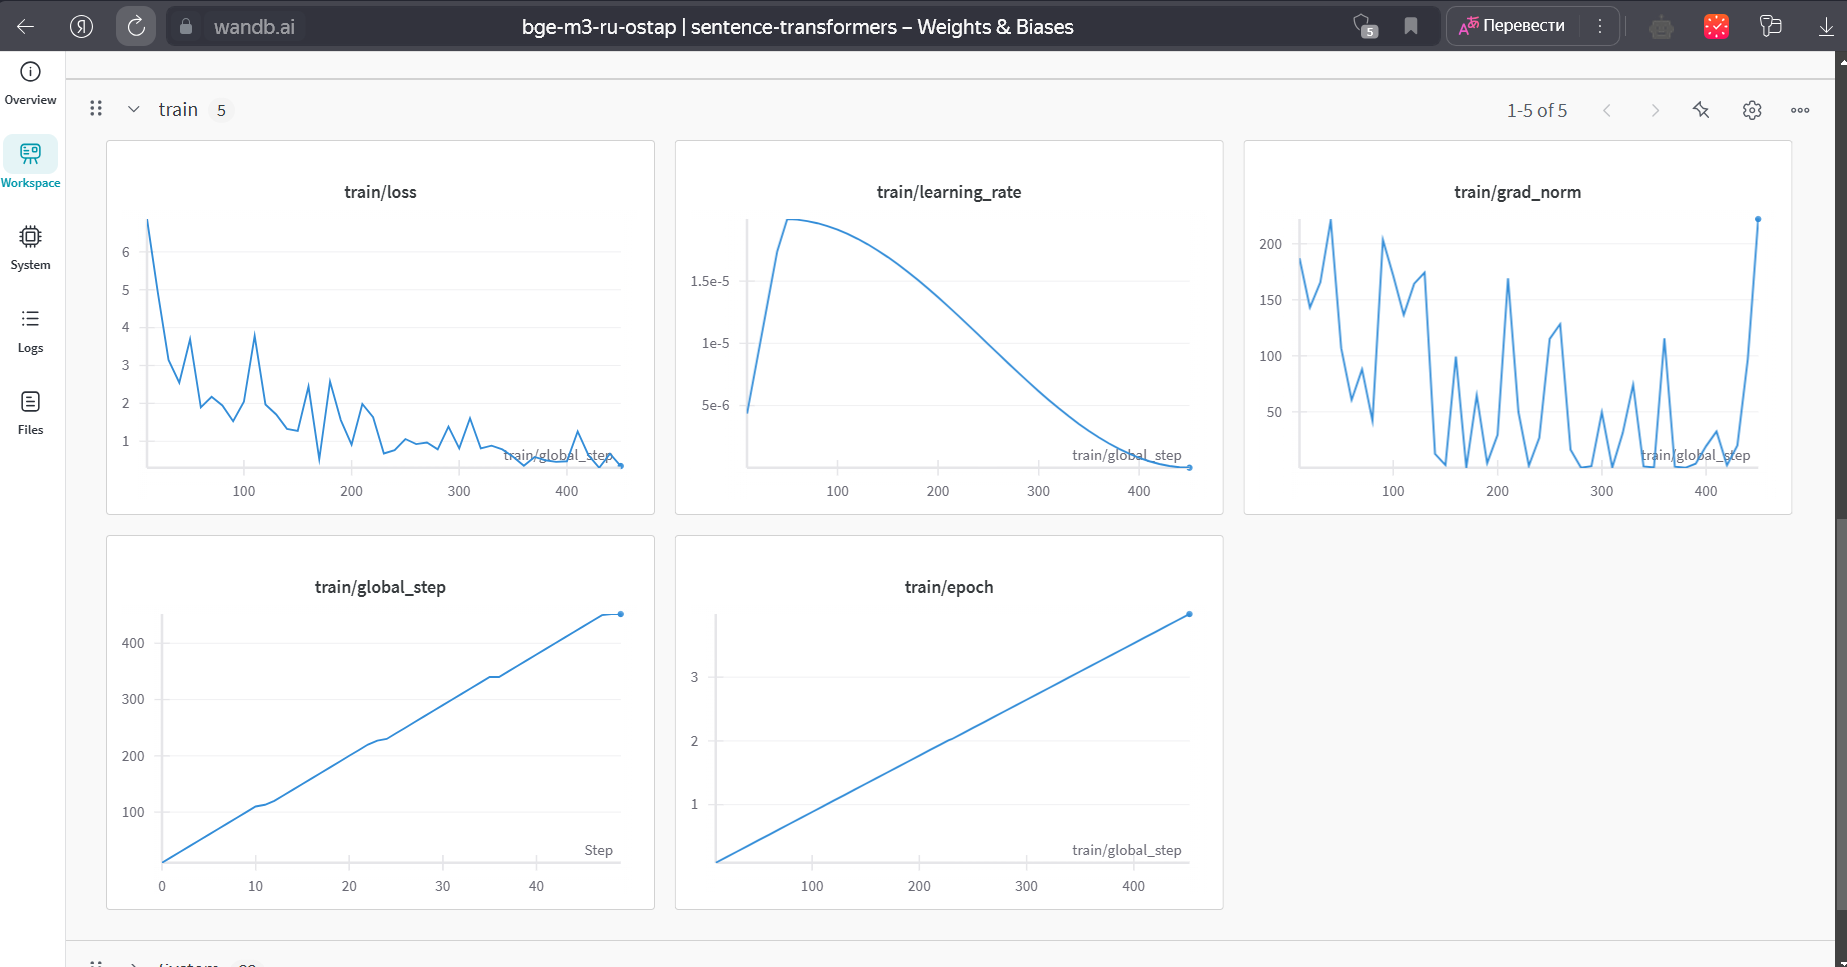

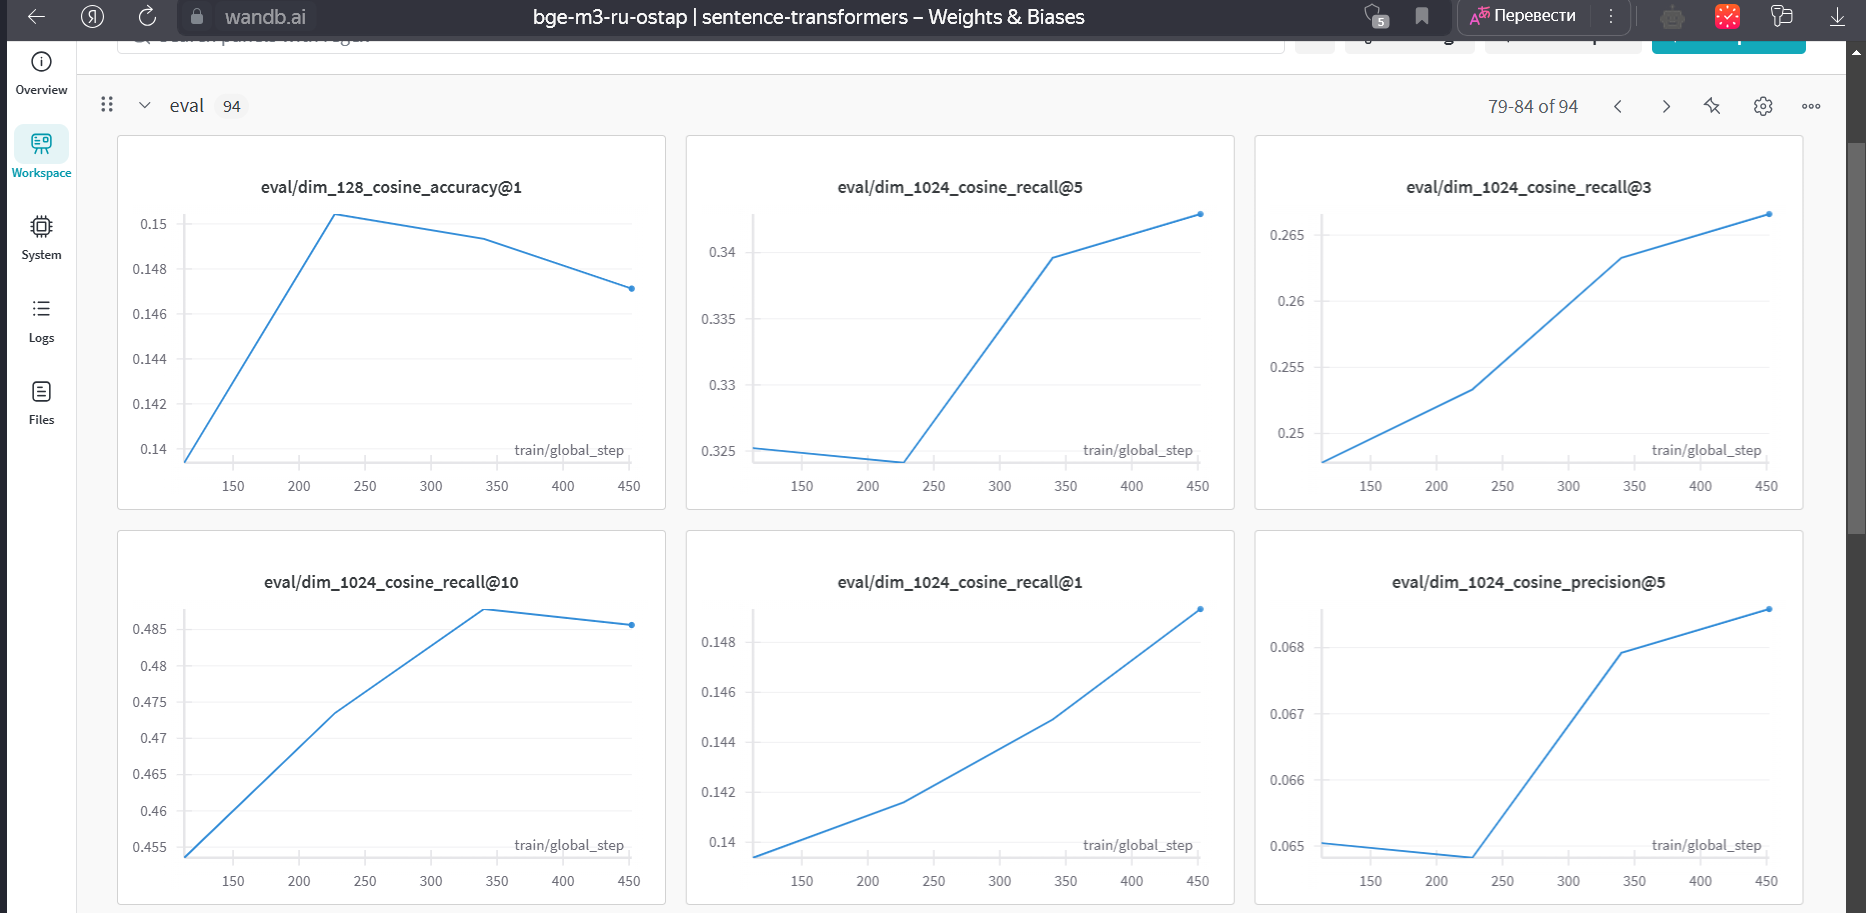

Можно увидеть, что метрика Recall@5 на синтетическом валидационном датасете была увеличена с 0.3252 до 0.3429

Loss на Traine падал

#### Benchmark на дообученной модели

In [14]:
finetuned_model = SentenceTransformer('fitlemon/bge-m3-ru-ostap', device=device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/35.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [15]:
results_finetuned = ir_evaluator(finetuned_model)

In [17]:
results_finetuned

{'Ostap-phrases_cosine_accuracy@1': 0.2168141592920354,
 'Ostap-phrases_cosine_accuracy@3': 0.42920353982300885,
 'Ostap-phrases_cosine_accuracy@5': 0.5973451327433629,
 'Ostap-phrases_cosine_accuracy@10': 0.7610619469026548,
 'Ostap-phrases_cosine_precision@1': 0.2168141592920354,
 'Ostap-phrases_cosine_precision@3': 0.1430678466076696,
 'Ostap-phrases_cosine_precision@5': 0.11946902654867257,
 'Ostap-phrases_cosine_precision@10': 0.07610619469026547,
 'Ostap-phrases_cosine_recall@1': 0.2168141592920354,
 'Ostap-phrases_cosine_recall@3': 0.42920353982300885,
 'Ostap-phrases_cosine_recall@5': 0.5973451327433629,
 'Ostap-phrases_cosine_recall@10': 0.7610619469026548,
 'Ostap-phrases_cosine_ndcg@10': 0.462654398255655,
 'Ostap-phrases_cosine_mrr@10': 0.3699202837477176,
 'Ostap-phrases_cosine_map@100': 0.3820314848953216}

In [ ]:
results = pd.DataFrame({
    "baseline_bge": results_bge,
    "finetuned_bge_4epoch_8_batch": results_finetuned
})

In [27]:
results

baseline_bge  finetuned_bge_4epoch_8_batch
Ostap-phrases_cosine_accuracy@1        0.176991                      0.216814
Ostap-phrases_cosine_accuracy@3        0.292035                      0.429204
Ostap-phrases_cosine_accuracy@5        0.362832                      0.597345
Ostap-phrases_cosine_accuracy@10       0.464602                      0.761062
Ostap-phrases_cosine_precision@1       0.176991                      0.216814
Ostap-phrases_cosine_precision@3       0.097345                      0.143068
Ostap-phrases_cosine_precision@5       0.072566                      0.119469
Ostap-phrases_cosine_precision@10      0.046460                      0.076106
Ostap-phrases_cosine_recall@1          0.176991                      0.216814
Ostap-phrases_cosine_recall@3          0.292035                      0.429204
Ostap-phrases_cosine_recall@5          0.362832                      0.597345
Ostap-phrases_cosine_recall@10         0.464602                      0.761062
Ostap-phrases_cosine_ndcg@10           0.304269                      0.462654
Ostap-phrases_cosine_mrr@10            0.255029                      0.369920
Ostap-phrases_cosine_map@100           0.273292                      0.382031

### Пример инференса:

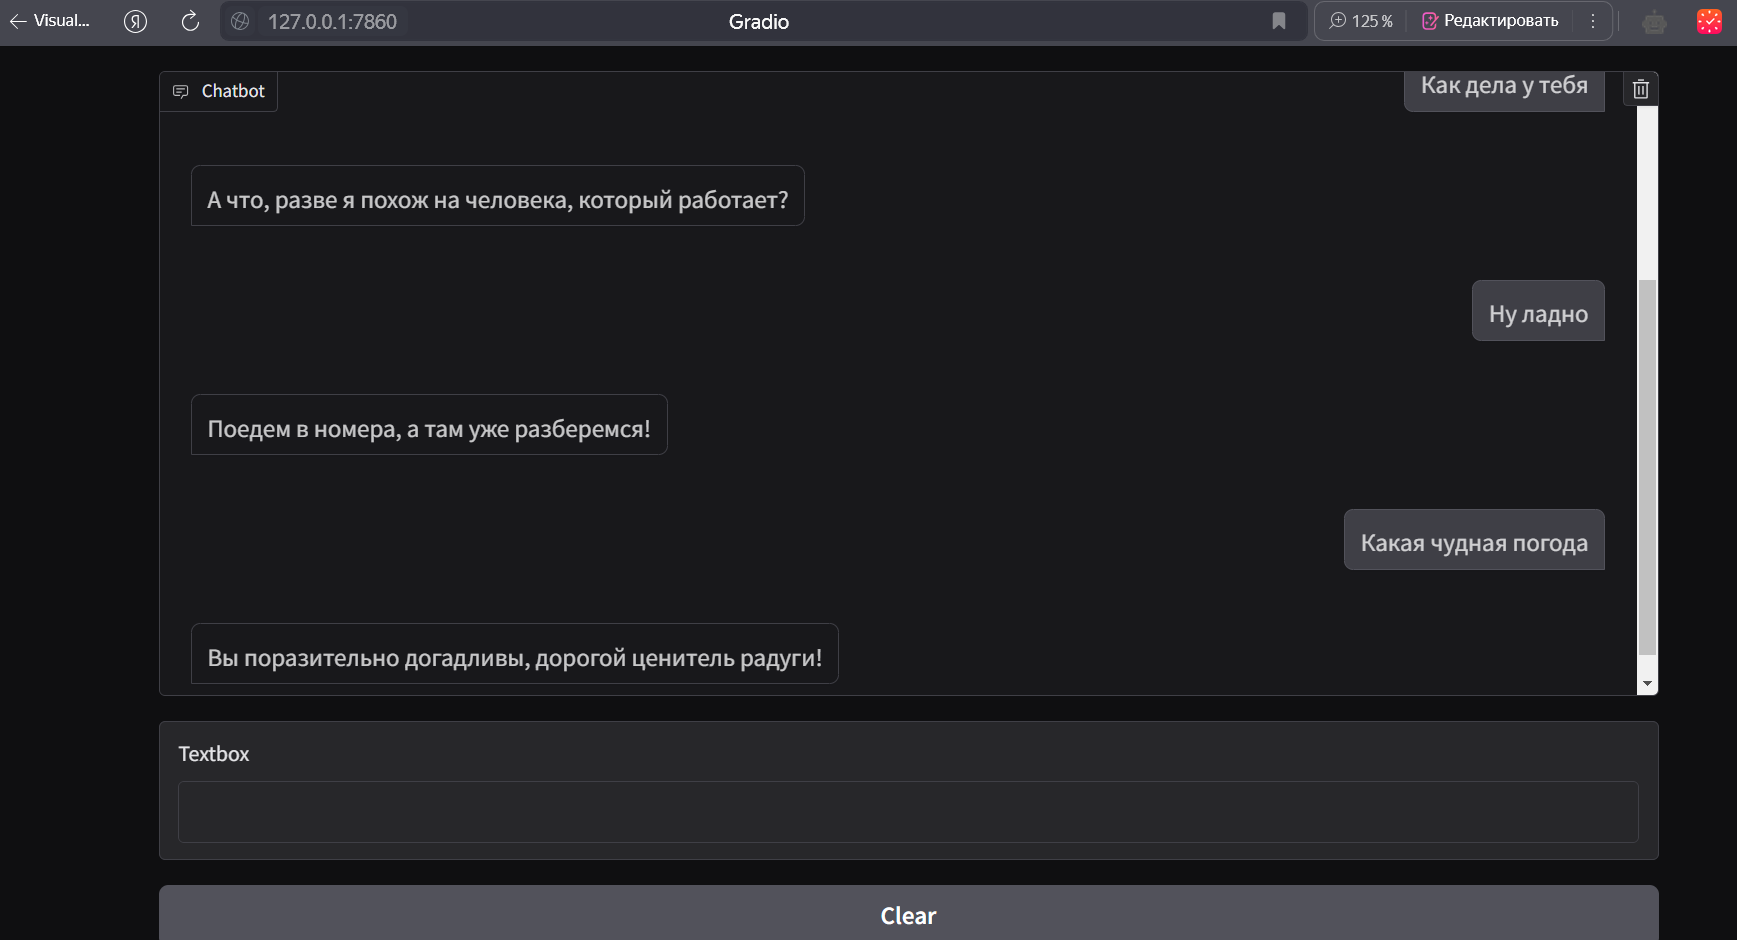